# **comparaison entre l'algorithme d'apprentissage par renforcement et méthode Otsu :**

## **variance intra-classe :**

Q-Learning process completed in 1375.52 seconds.
Optimal threshold found by Q-learning: 92
Otsu's method completed in 0.00 seconds.
Optimal threshold found by Otsu's method: 91.0
Entropy for Q-learning binarized image: 0.997341952553318
Entropy for Otsu's method binarized image: 0.9982843268936765


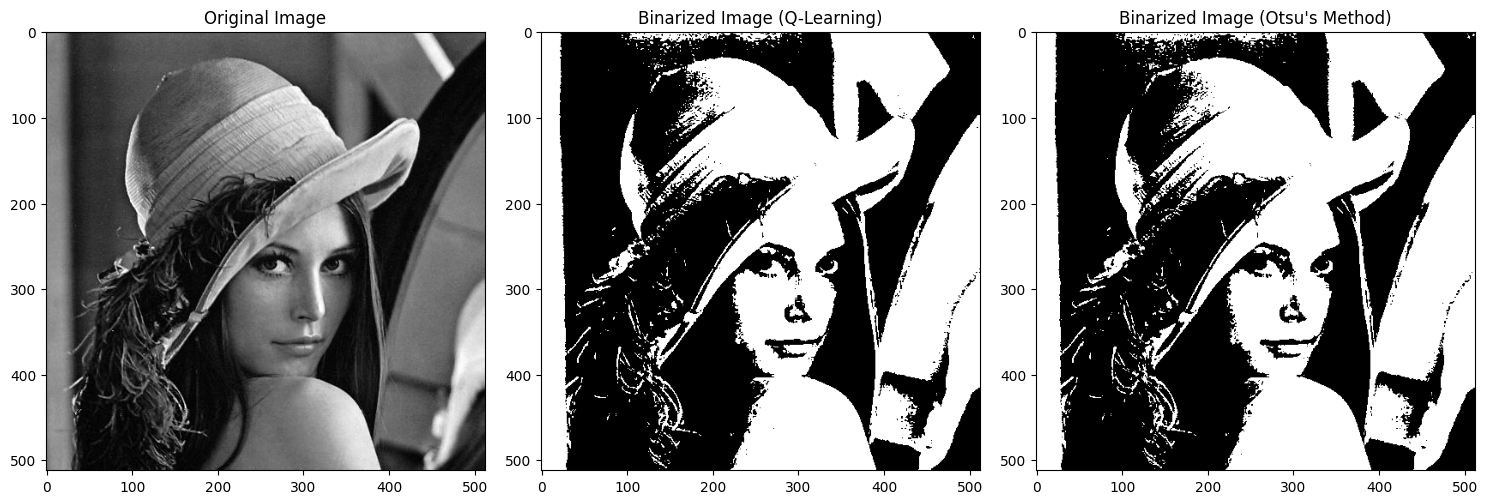

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time  # Import the time module

# Parameters for Q-Learning
learning_rate = 0.7
discount_factor = 0.9
epsilon = 1.0  # exploration rate
epsilon_decay = 0.995
min_epsilon = 0.1
num_episodes = 5000

# Environment parameters
threshold_levels = 256  # possible threshold levels (0-255)

# Initialize Q-table: threshold levels (256) x actions (2: binarize to 0 or 255)
q_table = np.zeros((threshold_levels, 2))

# Load image (convert to grayscale)
image = cv2.imread('lena.jpeg', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print("Error: The image was not found or loaded correctly. Please check the file path.")
    exit()

def get_state(pixel_value):
    """Returns the state, which is the pixel value itself."""
    return pixel_value

def choose_action(state, epsilon):
    """Epsilon-greedy action selection."""
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice([0, 1])  # Explore: choose randomly between binarizing to 0 or 255
    else:
        return np.argmax(q_table[state, :])  # Exploit: choose the best action based on Q-table

def take_action(action):
    """Apply the chosen action: 0 (binarize to 0) or 1 (binarize to 255)."""
    return 0 if action == 0 else 255

def variance_intra_classe(image, threshold):
    """Calculate the intra-class variance for a given threshold, similar to Otsu's method."""
    pixel_counts = np.bincount(image.ravel(), minlength=256)
    total_pixels = image.size

    # Probabilities for each class
    weight_background = np.sum(pixel_counts[:threshold]) / total_pixels
    weight_foreground = np.sum(pixel_counts[threshold:]) / total_pixels

    # Mean values for each class
    mean_background = np.sum(np.arange(0, threshold) * pixel_counts[:threshold]) / (np.sum(pixel_counts[:threshold]) + 1e-7)
    mean_foreground = np.sum(np.arange(threshold, 256) * pixel_counts[threshold:]) / (np.sum(pixel_counts[threshold:]) + 1e-7)

    # Variance for each class
    variance_background = np.sum(((np.arange(0, threshold) - mean_background) ** 2) * pixel_counts[:threshold]) / (np.sum(pixel_counts[:threshold]) + 1e-7)
    variance_foreground = np.sum(((np.arange(threshold, 256) - mean_foreground) ** 2) * pixel_counts[threshold:]) / (np.sum(pixel_counts[threshold:]) + 1e-7)

    # Weighted sum of variances (intra-class variance)
    intra_class_variance = weight_background * variance_background + weight_foreground * variance_foreground

    return intra_class_variance

def reward_function(image, threshold):
    """Reward function based on minimizing intra-class variance."""
    intra_class_variance = variance_intra_classe(image, threshold)
    return -intra_class_variance  # Minimize variance, so negative reward

def calculate_entropy(image):
    """Calculate the entropy of the image."""
    histogram, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    histogram = histogram[histogram > 0]  # Ignore zero entries
    probabilities = histogram / histogram.sum()
    return -np.sum(probabilities * np.log2(probabilities))

# Measure the time taken for the Q-Learning process
start_time = time.time()

# Q-Learning process
for episode in range(num_episodes):
    for threshold in range(threshold_levels):
        # Simulate the action for the entire image at the current threshold
        _, binarized_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

        # Calculate reward based on intra-class variance
        reward = reward_function(image, threshold)

        # Update Q-table using Bellman Equation for both actions (binarize to 0 or 255)
        for action in [0, 1]:
            q_table[threshold, action] = q_table[threshold, action] + learning_rate * (
                reward + discount_factor * np.max(q_table[threshold, :]) - q_table[threshold, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

end_time = time.time()
print(f"Q-Learning process completed in {end_time - start_time:.2f} seconds.")

# Find the optimal threshold
optimal_threshold = np.argmax(np.max(q_table, axis=1))
print(f"Optimal threshold found by Q-learning: {optimal_threshold}")

# Measure the time taken for Otsu's method
start_time_otsu = time.time()

# Apply optimal threshold to the image using Q-learning
_, binarized_image_optimal = cv2.threshold(image, optimal_threshold, 255, cv2.THRESH_BINARY)

# Apply Otsu's method
optimal_threshold_otsu, binarized_image_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

end_time_otsu = time.time()
print(f"Otsu's method completed in {end_time_otsu - start_time_otsu:.2f} seconds.")
print(f"Optimal threshold found by Otsu's method: {optimal_threshold_otsu}")

# Calculate Entropy
entropy_q_learning = calculate_entropy(binarized_image_optimal)
entropy_otsu = calculate_entropy(binarized_image_otsu)

print(f"Entropy for Q-learning binarized image: {entropy_q_learning}")
print(f"Entropy for Otsu's method binarized image: {entropy_otsu}")

# Plot original image, Q-learning binarized image, and Otsu binarized image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Binarized Image (Q-Learning)')
plt.imshow(binarized_image_optimal, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Binarized Image (Otsu\'s Method)')
plt.imshow(binarized_image_otsu, cmap='gray')

plt.tight_layout()
plt.show()


**Performance** : La méthode Q-Learning a pris beaucoup plus de temps que la méthode d'Otsu, ce qui est attendu en raison de la nature itérative de l'apprentissage par renforcement.

**Valeurs des seuils** : Les seuils optimaux trouvés sont très proches (92 pour Q-Learning et 91 pour Otsu), ce qui indique que les deux méthodes sont efficaces pour déterminer un seuil approprié pour la binarisation.

**Entropie** : les deux valeurs sont relativement proches, et comme l'entropie de la méthode d'Otsu est légèrement plus élevée, cela indique qu'elle préserve un peu plus de détails ou de variations par rapport à la méthode Q-learning dans ce cas.

Q-Learning process completed in 1307.62 seconds.
Optimal threshold found by Q-learning: 89
Otsu's method completed in 0.00 seconds.
Optimal threshold found by Otsu's method: 88.0
Entropy for Q-learning binarized image: 0.8388421646815805
Entropy for Otsu's method binarized image: 0.8371499486004521


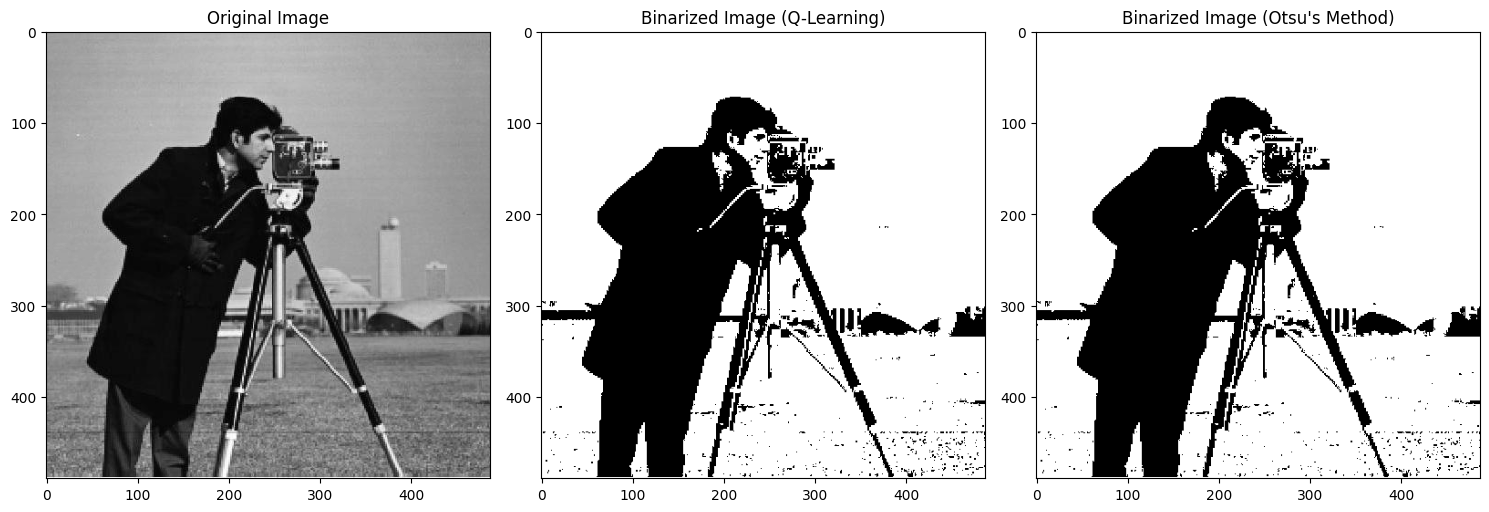

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time  # Import the time module

# Parameters for Q-Learning
learning_rate = 0.7
discount_factor = 0.9
epsilon = 1.0  # exploration rate
epsilon_decay = 0.995
min_epsilon = 0.1
num_episodes = 5000

# Environment parameters
threshold_levels = 256  # possible threshold levels (0-255)

# Initialize Q-table: threshold levels (256) x actions (2: binarize to 0 or 255)
q_table = np.zeros((threshold_levels, 2))

# Load image (convert to grayscale)
image = cv2.imread('kameraman.jpeg', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print("Error: The image was not found or loaded correctly. Please check the file path.")
    exit()

def get_state(pixel_value):
    """Returns the state, which is the pixel value itself."""
    return pixel_value

def choose_action(state, epsilon):
    """Epsilon-greedy action selection."""
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice([0, 1])  # Explore: choose randomly between binarizing to 0 or 255
    else:
        return np.argmax(q_table[state, :])  # Exploit: choose the best action based on Q-table

def take_action(action):
    """Apply the chosen action: 0 (binarize to 0) or 1 (binarize to 255)."""
    return 0 if action == 0 else 255

def variance_intra_classe(image, threshold):
    """Calculate the intra-class variance for a given threshold, similar to Otsu's method."""
    pixel_counts = np.bincount(image.ravel(), minlength=256)
    total_pixels = image.size

    # Probabilities for each class
    weight_background = np.sum(pixel_counts[:threshold]) / total_pixels
    weight_foreground = np.sum(pixel_counts[threshold:]) / total_pixels

    # Mean values for each class
    mean_background = np.sum(np.arange(0, threshold) * pixel_counts[:threshold]) / (np.sum(pixel_counts[:threshold]) + 1e-7)
    mean_foreground = np.sum(np.arange(threshold, 256) * pixel_counts[threshold:]) / (np.sum(pixel_counts[threshold:]) + 1e-7)

    # Variance for each class
    variance_background = np.sum(((np.arange(0, threshold) - mean_background) ** 2) * pixel_counts[:threshold]) / (np.sum(pixel_counts[:threshold]) + 1e-7)
    variance_foreground = np.sum(((np.arange(threshold, 256) - mean_foreground) ** 2) * pixel_counts[threshold:]) / (np.sum(pixel_counts[threshold:]) + 1e-7)

    # Weighted sum of variances (intra-class variance)
    intra_class_variance = weight_background * variance_background + weight_foreground * variance_foreground

    return intra_class_variance

def reward_function(image, threshold):
    """Reward function based on minimizing intra-class variance."""
    intra_class_variance = variance_intra_classe(image, threshold)
    return -intra_class_variance  # Minimize variance, so negative reward

def calculate_entropy(image):
    """Calculate the entropy of the image."""
    histogram, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    histogram = histogram[histogram > 0]  # Ignore zero entries
    probabilities = histogram / histogram.sum()
    return -np.sum(probabilities * np.log2(probabilities))

# Measure the time taken for the Q-Learning process
start_time = time.time()

# Q-Learning process
for episode in range(num_episodes):
    for threshold in range(threshold_levels):
        # Simulate the action for the entire image at the current threshold
        _, binarized_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

        # Calculate reward based on intra-class variance
        reward = reward_function(image, threshold)

        # Update Q-table using Bellman Equation for both actions (binarize to 0 or 255)
        for action in [0, 1]:
            q_table[threshold, action] = q_table[threshold, action] + learning_rate * (
                reward + discount_factor * np.max(q_table[threshold, :]) - q_table[threshold, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

end_time = time.time()
print(f"Q-Learning process completed in {end_time - start_time:.2f} seconds.")

# Find the optimal threshold
optimal_threshold = np.argmax(np.max(q_table, axis=1))
print(f"Optimal threshold found by Q-learning: {optimal_threshold}")

# Measure the time taken for Otsu's method
start_time_otsu = time.time()

# Apply optimal threshold to the image using Q-learning
_, binarized_image_optimal = cv2.threshold(image, optimal_threshold, 255, cv2.THRESH_BINARY)

# Apply Otsu's method
optimal_threshold_otsu, binarized_image_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

end_time_otsu = time.time()
print(f"Otsu's method completed in {end_time_otsu - start_time_otsu:.2f} seconds.")
print(f"Optimal threshold found by Otsu's method: {optimal_threshold_otsu}")

# Calculate Entropy
entropy_q_learning = calculate_entropy(binarized_image_optimal)
entropy_otsu = calculate_entropy(binarized_image_otsu)

print(f"Entropy for Q-learning binarized image: {entropy_q_learning}")
print(f"Entropy for Otsu's method binarized image: {entropy_otsu}")

# Plot original image, Q-learning binarized image, and Otsu binarized image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Binarized Image (Q-Learning)')
plt.imshow(binarized_image_optimal, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Binarized Image (Otsu\'s Method)')
plt.imshow(binarized_image_otsu, cmap='gray')

plt.tight_layout()
plt.show()


Q-Learning process completed in 313.18 seconds.
Optimal threshold found by Q-learning: 114
Otsu's method completed in 0.00 seconds.
Optimal threshold found by Otsu's method: 113.0
Entropy for Q-learning binarized image: 0.997412770285022
Entropy for Otsu's method binarized image: 0.9968069257493657


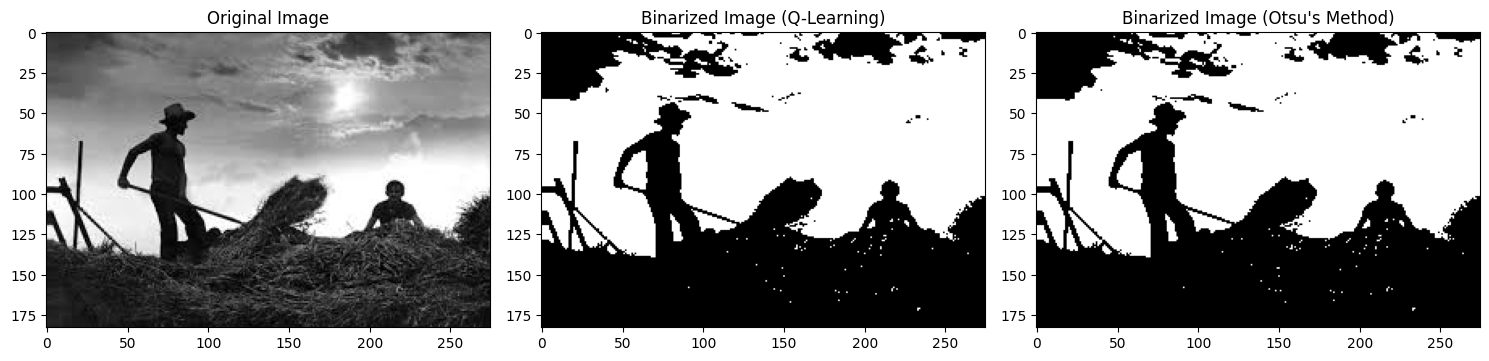

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time  # Import the time module

# Parameters for Q-Learning
learning_rate = 0.7
discount_factor = 0.9
epsilon = 1.0  # exploration rate
epsilon_decay = 0.995
min_epsilon = 0.1
num_episodes = 5000

# Environment parameters
threshold_levels = 256  # possible threshold levels (0-255)

# Initialize Q-table: threshold levels (256) x actions (2: binarize to 0 or 255)
q_table = np.zeros((threshold_levels, 2))

# Load image (convert to grayscale)
image = cv2.imread('jardinier.jfif', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print("Error: The image was not found or loaded correctly. Please check the file path.")
    exit()

def get_state(pixel_value):
    """Returns the state, which is the pixel value itself."""
    return pixel_value

def choose_action(state, epsilon):
    """Epsilon-greedy action selection."""
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice([0, 1])  # Explore: choose randomly between binarizing to 0 or 255
    else:
        return np.argmax(q_table[state, :])  # Exploit: choose the best action based on Q-table

def take_action(action):
    """Apply the chosen action: 0 (binarize to 0) or 1 (binarize to 255)."""
    return 0 if action == 0 else 255

def variance_intra_classe(image, threshold):
    """Calculate the intra-class variance for a given threshold, similar to Otsu's method."""
    pixel_counts = np.bincount(image.ravel(), minlength=256)
    total_pixels = image.size

    # Probabilities for each class
    weight_background = np.sum(pixel_counts[:threshold]) / total_pixels
    weight_foreground = np.sum(pixel_counts[threshold:]) / total_pixels

    # Mean values for each class
    mean_background = np.sum(np.arange(0, threshold) * pixel_counts[:threshold]) / (np.sum(pixel_counts[:threshold]) + 1e-7)
    mean_foreground = np.sum(np.arange(threshold, 256) * pixel_counts[threshold:]) / (np.sum(pixel_counts[threshold:]) + 1e-7)

    # Variance for each class
    variance_background = np.sum(((np.arange(0, threshold) - mean_background) ** 2) * pixel_counts[:threshold]) / (np.sum(pixel_counts[:threshold]) + 1e-7)
    variance_foreground = np.sum(((np.arange(threshold, 256) - mean_foreground) ** 2) * pixel_counts[threshold:]) / (np.sum(pixel_counts[threshold:]) + 1e-7)

    # Weighted sum of variances (intra-class variance)
    intra_class_variance = weight_background * variance_background + weight_foreground * variance_foreground

    return intra_class_variance

def reward_function(image, threshold):
    """Reward function based on minimizing intra-class variance."""
    intra_class_variance = variance_intra_classe(image, threshold)
    return -intra_class_variance  # Minimize variance, so negative reward

def calculate_entropy(image):
    """Calculate the entropy of the image."""
    histogram, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    histogram = histogram[histogram > 0]  # Ignore zero entries
    probabilities = histogram / histogram.sum()
    return -np.sum(probabilities * np.log2(probabilities))

# Measure the time taken for the Q-Learning process
start_time = time.time()

# Q-Learning process
for episode in range(num_episodes):
    for threshold in range(threshold_levels):
        # Simulate the action for the entire image at the current threshold
        _, binarized_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

        # Calculate reward based on intra-class variance
        reward = reward_function(image, threshold)

        # Update Q-table using Bellman Equation for both actions (binarize to 0 or 255)
        for action in [0, 1]:
            q_table[threshold, action] = q_table[threshold, action] + learning_rate * (
                reward + discount_factor * np.max(q_table[threshold, :]) - q_table[threshold, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

end_time = time.time()
print(f"Q-Learning process completed in {end_time - start_time:.2f} seconds.")

# Find the optimal threshold
optimal_threshold = np.argmax(np.max(q_table, axis=1))
print(f"Optimal threshold found by Q-learning: {optimal_threshold}")

# Measure the time taken for Otsu's method
start_time_otsu = time.time()

# Apply optimal threshold to the image using Q-learning
_, binarized_image_optimal = cv2.threshold(image, optimal_threshold, 255, cv2.THRESH_BINARY)

# Apply Otsu's method
optimal_threshold_otsu, binarized_image_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

end_time_otsu = time.time()
print(f"Otsu's method completed in {end_time_otsu - start_time_otsu:.2f} seconds.")
print(f"Optimal threshold found by Otsu's method: {optimal_threshold_otsu}")

# Calculate Entropy
entropy_q_learning = calculate_entropy(binarized_image_optimal)
entropy_otsu = calculate_entropy(binarized_image_otsu)

print(f"Entropy for Q-learning binarized image: {entropy_q_learning}")
print(f"Entropy for Otsu's method binarized image: {entropy_otsu}")

# Plot original image, Q-learning binarized image, and Otsu binarized image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Binarized Image (Q-Learning)')
plt.imshow(binarized_image_optimal, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Binarized Image (Otsu\'s Method)')
plt.imshow(binarized_image_otsu, cmap='gray')

plt.tight_layout()
plt.show()


Q-Learning process completed in 306.06 seconds.
Optimal threshold found by Q-learning: 108
Otsu's method completed in 0.00 seconds.
Optimal threshold found by Otsu's method: 107.0
Entropy for Q-learning binarized image: 0.9991020811254497
Entropy for Otsu's method binarized image: 0.9997091469098178


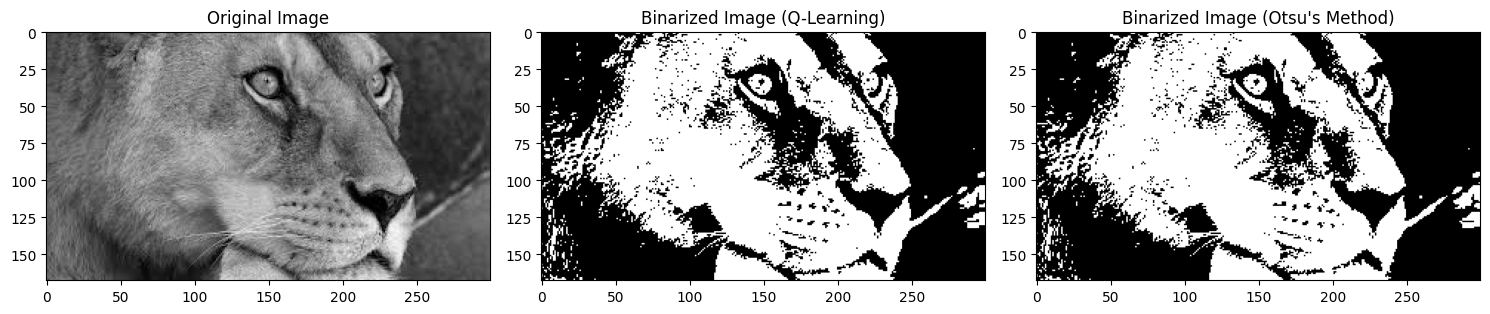

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time  # Import the time module

# Parameters for Q-Learning
learning_rate = 0.7
discount_factor = 0.9
epsilon = 1.0  # exploration rate
epsilon_decay = 0.995
min_epsilon = 0.1
num_episodes = 5000

# Environment parameters
threshold_levels = 256  # possible threshold levels (0-255)

# Initialize Q-table: threshold levels (256) x actions (2: binarize to 0 or 255)
q_table = np.zeros((threshold_levels, 2))

# Load image (convert to grayscale)
image = cv2.imread('lion2.jfif', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print("Error: The image was not found or loaded correctly. Please check the file path.")
    exit()

def get_state(pixel_value):
    """Returns the state, which is the pixel value itself."""
    return pixel_value

def choose_action(state, epsilon):
    """Epsilon-greedy action selection."""
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice([0, 1])  # Explore: choose randomly between binarizing to 0 or 255
    else:
        return np.argmax(q_table[state, :])  # Exploit: choose the best action based on Q-table

def take_action(action):
    """Apply the chosen action: 0 (binarize to 0) or 1 (binarize to 255)."""
    return 0 if action == 0 else 255

def variance_intra_classe(image, threshold):
    """Calculate the intra-class variance for a given threshold, similar to Otsu's method."""
    pixel_counts = np.bincount(image.ravel(), minlength=256)
    total_pixels = image.size

    # Probabilities for each class
    weight_background = np.sum(pixel_counts[:threshold]) / total_pixels
    weight_foreground = np.sum(pixel_counts[threshold:]) / total_pixels

    # Mean values for each class
    mean_background = np.sum(np.arange(0, threshold) * pixel_counts[:threshold]) / (np.sum(pixel_counts[:threshold]) + 1e-7)
    mean_foreground = np.sum(np.arange(threshold, 256) * pixel_counts[threshold:]) / (np.sum(pixel_counts[threshold:]) + 1e-7)

    # Variance for each class
    variance_background = np.sum(((np.arange(0, threshold) - mean_background) ** 2) * pixel_counts[:threshold]) / (np.sum(pixel_counts[:threshold]) + 1e-7)
    variance_foreground = np.sum(((np.arange(threshold, 256) - mean_foreground) ** 2) * pixel_counts[threshold:]) / (np.sum(pixel_counts[threshold:]) + 1e-7)

    # Weighted sum of variances (intra-class variance)
    intra_class_variance = weight_background * variance_background + weight_foreground * variance_foreground

    return intra_class_variance

def reward_function(image, threshold):
    """Reward function based on minimizing intra-class variance."""
    intra_class_variance = variance_intra_classe(image, threshold)
    return -intra_class_variance  # Minimize variance, so negative reward

def calculate_entropy(image):
    """Calculate the entropy of the image."""
    histogram, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    histogram = histogram[histogram > 0]  # Ignore zero entries
    probabilities = histogram / histogram.sum()
    return -np.sum(probabilities * np.log2(probabilities))

# Measure the time taken for the Q-Learning process
start_time = time.time()

# Q-Learning process
for episode in range(num_episodes):
    for threshold in range(threshold_levels):
        # Simulate the action for the entire image at the current threshold
        _, binarized_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

        # Calculate reward based on intra-class variance
        reward = reward_function(image, threshold)

        # Update Q-table using Bellman Equation for both actions (binarize to 0 or 255)
        for action in [0, 1]:
            q_table[threshold, action] = q_table[threshold, action] + learning_rate * (
                reward + discount_factor * np.max(q_table[threshold, :]) - q_table[threshold, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

end_time = time.time()
print(f"Q-Learning process completed in {end_time - start_time:.2f} seconds.")

# Find the optimal threshold
optimal_threshold = np.argmax(np.max(q_table, axis=1))
print(f"Optimal threshold found by Q-learning: {optimal_threshold}")

# Measure the time taken for Otsu's method
start_time_otsu = time.time()

# Apply optimal threshold to the image using Q-learning
_, binarized_image_optimal = cv2.threshold(image, optimal_threshold, 255, cv2.THRESH_BINARY)

# Apply Otsu's method
optimal_threshold_otsu, binarized_image_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

end_time_otsu = time.time()
print(f"Otsu's method completed in {end_time_otsu - start_time_otsu:.2f} seconds.")
print(f"Optimal threshold found by Otsu's method: {optimal_threshold_otsu}")

# Calculate Entropy
entropy_q_learning = calculate_entropy(binarized_image_optimal)
entropy_otsu = calculate_entropy(binarized_image_otsu)

print(f"Entropy for Q-learning binarized image: {entropy_q_learning}")
print(f"Entropy for Otsu's method binarized image: {entropy_otsu}")

# Plot original image, Q-learning binarized image, and Otsu binarized image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Binarized Image (Q-Learning)')
plt.imshow(binarized_image_optimal, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Binarized Image (Otsu\'s Method)')
plt.imshow(binarized_image_otsu, cmap='gray')

plt.tight_layout()
plt.show()


Q-Learning process completed in 314.52 seconds.
Optimal threshold found by Q-learning: 105
Otsu's method completed in 0.00 seconds.
Optimal threshold found by Otsu's method: 104.0
Entropy for Q-learning binarized image: 0.7490315376554855
Entropy for Otsu's method binarized image: 0.760041242925255


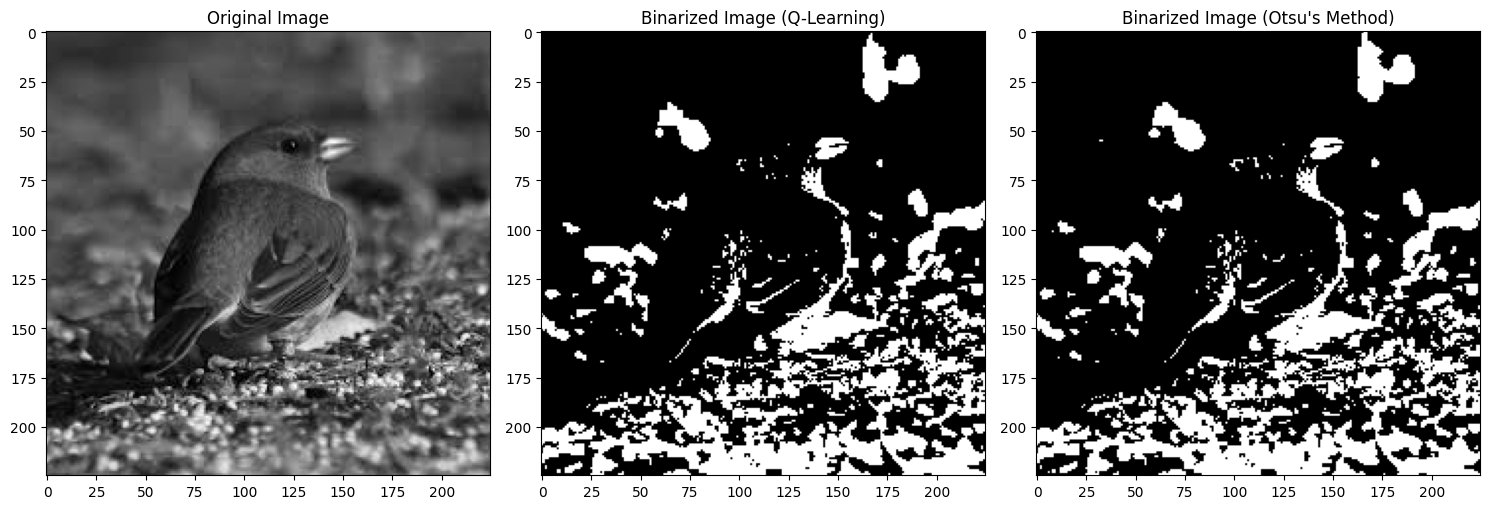

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time  # Import the time module

# Parameters for Q-Learning
learning_rate = 0.7
discount_factor = 0.9
epsilon = 1.0  # exploration rate
epsilon_decay = 0.995
min_epsilon = 0.1
num_episodes = 5000

# Environment parameters
threshold_levels = 256  # possible threshold levels (0-255)

# Initialize Q-table: threshold levels (256) x actions (2: binarize to 0 or 255)
q_table = np.zeros((threshold_levels, 2))

# Load image (convert to grayscale)
image = cv2.imread('oiseau.jfif', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print("Error: The image was not found or loaded correctly. Please check the file path.")
    exit()

def get_state(pixel_value):
    """Returns the state, which is the pixel value itself."""
    return pixel_value

def choose_action(state, epsilon):
    """Epsilon-greedy action selection."""
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice([0, 1])  # Explore: choose randomly between binarizing to 0 or 255
    else:
        return np.argmax(q_table[state, :])  # Exploit: choose the best action based on Q-table

def take_action(action):
    """Apply the chosen action: 0 (binarize to 0) or 1 (binarize to 255)."""
    return 0 if action == 0 else 255

def variance_intra_classe(image, threshold):
    """Calculate the intra-class variance for a given threshold, similar to Otsu's method."""
    pixel_counts = np.bincount(image.ravel(), minlength=256)
    total_pixels = image.size

    # Probabilities for each class
    weight_background = np.sum(pixel_counts[:threshold]) / total_pixels
    weight_foreground = np.sum(pixel_counts[threshold:]) / total_pixels

    # Mean values for each class
    mean_background = np.sum(np.arange(0, threshold) * pixel_counts[:threshold]) / (np.sum(pixel_counts[:threshold]) + 1e-7)
    mean_foreground = np.sum(np.arange(threshold, 256) * pixel_counts[threshold:]) / (np.sum(pixel_counts[threshold:]) + 1e-7)

    # Variance for each class
    variance_background = np.sum(((np.arange(0, threshold) - mean_background) ** 2) * pixel_counts[:threshold]) / (np.sum(pixel_counts[:threshold]) + 1e-7)
    variance_foreground = np.sum(((np.arange(threshold, 256) - mean_foreground) ** 2) * pixel_counts[threshold:]) / (np.sum(pixel_counts[threshold:]) + 1e-7)

    # Weighted sum of variances (intra-class variance)
    intra_class_variance = weight_background * variance_background + weight_foreground * variance_foreground

    return intra_class_variance

def reward_function(image, threshold):
    """Reward function based on minimizing intra-class variance."""
    intra_class_variance = variance_intra_classe(image, threshold)
    return -intra_class_variance  # Minimize variance, so negative reward

def calculate_entropy(image):
    """Calculate the entropy of the image."""
    histogram, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    histogram = histogram[histogram > 0]  # Ignore zero entries
    probabilities = histogram / histogram.sum()
    return -np.sum(probabilities * np.log2(probabilities))

# Measure the time taken for the Q-Learning process
start_time = time.time()

# Q-Learning process
for episode in range(num_episodes):
    for threshold in range(threshold_levels):
        # Simulate the action for the entire image at the current threshold
        _, binarized_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

        # Calculate reward based on intra-class variance
        reward = reward_function(image, threshold)

        # Update Q-table using Bellman Equation for both actions (binarize to 0 or 255)
        for action in [0, 1]:
            q_table[threshold, action] = q_table[threshold, action] + learning_rate * (
                reward + discount_factor * np.max(q_table[threshold, :]) - q_table[threshold, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

end_time = time.time()
print(f"Q-Learning process completed in {end_time - start_time:.2f} seconds.")

# Find the optimal threshold
optimal_threshold = np.argmax(np.max(q_table, axis=1))
print(f"Optimal threshold found by Q-learning: {optimal_threshold}")

# Measure the time taken for Otsu's method
start_time_otsu = time.time()

# Apply optimal threshold to the image using Q-learning
_, binarized_image_optimal = cv2.threshold(image, optimal_threshold, 255, cv2.THRESH_BINARY)

# Apply Otsu's method
optimal_threshold_otsu, binarized_image_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

end_time_otsu = time.time()
print(f"Otsu's method completed in {end_time_otsu - start_time_otsu:.2f} seconds.")
print(f"Optimal threshold found by Otsu's method: {optimal_threshold_otsu}")

# Calculate Entropy
entropy_q_learning = calculate_entropy(binarized_image_optimal)
entropy_otsu = calculate_entropy(binarized_image_otsu)

print(f"Entropy for Q-learning binarized image: {entropy_q_learning}")
print(f"Entropy for Otsu's method binarized image: {entropy_otsu}")

# Plot original image, Q-learning binarized image, and Otsu binarized image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Binarized Image (Q-Learning)')
plt.imshow(binarized_image_optimal, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Binarized Image (Otsu\'s Method)')
plt.imshow(binarized_image_otsu, cmap='gray')

plt.tight_layout()
plt.show()


Q-Learning process completed in 314.20 seconds.
Optimal threshold found by Q-learning: 123
Otsu's method completed in 0.00 seconds.
Optimal threshold found by Otsu's method: 122.0
Entropy for Q-learning binarized image: 0.8899843708242734
Entropy for Otsu's method binarized image: 0.8947009158778796


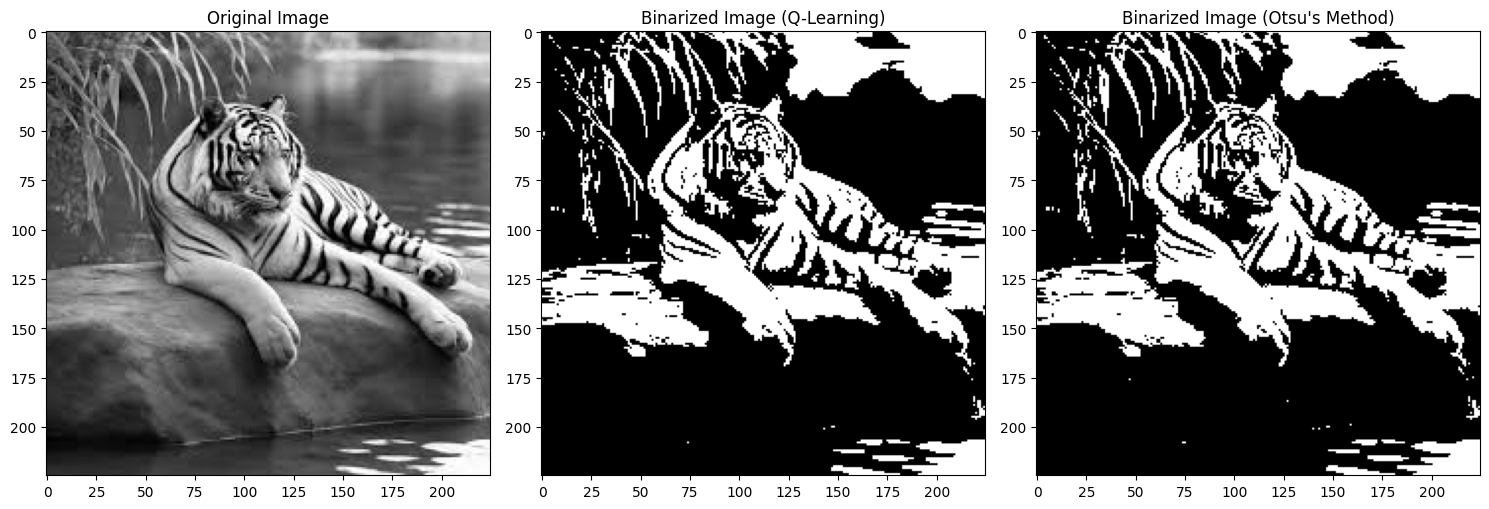

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time  # Import the time module

# Parameters for Q-Learning
learning_rate = 0.7
discount_factor = 0.9
epsilon = 1.0  # exploration rate
epsilon_decay = 0.995
min_epsilon = 0.1
num_episodes = 5000

# Environment parameters
threshold_levels = 256  # possible threshold levels (0-255)

# Initialize Q-table: threshold levels (256) x actions (2: binarize to 0 or 255)
q_table = np.zeros((threshold_levels, 2))

# Load image (convert to grayscale)
image = cv2.imread('riviere.jfif', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print("Error: The image was not found or loaded correctly. Please check the file path.")
    exit()

def get_state(pixel_value):
    """Returns the state, which is the pixel value itself."""
    return pixel_value

def choose_action(state, epsilon):
    """Epsilon-greedy action selection."""
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice([0, 1])  # Explore: choose randomly between binarizing to 0 or 255
    else:
        return np.argmax(q_table[state, :])  # Exploit: choose the best action based on Q-table

def take_action(action):
    """Apply the chosen action: 0 (binarize to 0) or 1 (binarize to 255)."""
    return 0 if action == 0 else 255

def variance_intra_classe(image, threshold):
    """Calculate the intra-class variance for a given threshold, similar to Otsu's method."""
    pixel_counts = np.bincount(image.ravel(), minlength=256)
    total_pixels = image.size

    # Probabilities for each class
    weight_background = np.sum(pixel_counts[:threshold]) / total_pixels
    weight_foreground = np.sum(pixel_counts[threshold:]) / total_pixels

    # Mean values for each class
    mean_background = np.sum(np.arange(0, threshold) * pixel_counts[:threshold]) / (np.sum(pixel_counts[:threshold]) + 1e-7)
    mean_foreground = np.sum(np.arange(threshold, 256) * pixel_counts[threshold:]) / (np.sum(pixel_counts[threshold:]) + 1e-7)

    # Variance for each class
    variance_background = np.sum(((np.arange(0, threshold) - mean_background) ** 2) * pixel_counts[:threshold]) / (np.sum(pixel_counts[:threshold]) + 1e-7)
    variance_foreground = np.sum(((np.arange(threshold, 256) - mean_foreground) ** 2) * pixel_counts[threshold:]) / (np.sum(pixel_counts[threshold:]) + 1e-7)

    # Weighted sum of variances (intra-class variance)
    intra_class_variance = weight_background * variance_background + weight_foreground * variance_foreground

    return intra_class_variance

def reward_function(image, threshold):
    """Reward function based on minimizing intra-class variance."""
    intra_class_variance = variance_intra_classe(image, threshold)
    return -intra_class_variance  # Minimize variance, so negative reward

def calculate_entropy(image):
    """Calculate the entropy of the image."""
    histogram, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    histogram = histogram[histogram > 0]  # Ignore zero entries
    probabilities = histogram / histogram.sum()
    return -np.sum(probabilities * np.log2(probabilities))

# Measure the time taken for the Q-Learning process
start_time = time.time()

# Q-Learning process
for episode in range(num_episodes):
    for threshold in range(threshold_levels):
        # Simulate the action for the entire image at the current threshold
        _, binarized_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

        # Calculate reward based on intra-class variance
        reward = reward_function(image, threshold)

        # Update Q-table using Bellman Equation for both actions (binarize to 0 or 255)
        for action in [0, 1]:
            q_table[threshold, action] = q_table[threshold, action] + learning_rate * (
                reward + discount_factor * np.max(q_table[threshold, :]) - q_table[threshold, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

end_time = time.time()
print(f"Q-Learning process completed in {end_time - start_time:.2f} seconds.")

# Find the optimal threshold
optimal_threshold = np.argmax(np.max(q_table, axis=1))
print(f"Optimal threshold found by Q-learning: {optimal_threshold}")

# Measure the time taken for Otsu's method
start_time_otsu = time.time()

# Apply optimal threshold to the image using Q-learning
_, binarized_image_optimal = cv2.threshold(image, optimal_threshold, 255, cv2.THRESH_BINARY)

# Apply Otsu's method
optimal_threshold_otsu, binarized_image_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

end_time_otsu = time.time()
print(f"Otsu's method completed in {end_time_otsu - start_time_otsu:.2f} seconds.")
print(f"Optimal threshold found by Otsu's method: {optimal_threshold_otsu}")

# Calculate Entropy
entropy_q_learning = calculate_entropy(binarized_image_optimal)
entropy_otsu = calculate_entropy(binarized_image_otsu)

print(f"Entropy for Q-learning binarized image: {entropy_q_learning}")
print(f"Entropy for Otsu's method binarized image: {entropy_otsu}")

# Plot original image, Q-learning binarized image, and Otsu binarized image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Binarized Image (Q-Learning)')
plt.imshow(binarized_image_optimal, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Binarized Image (Otsu\'s Method)')
plt.imshow(binarized_image_otsu, cmap='gray')

plt.tight_layout()
plt.show()


Q-Learning process completed in 313.15 seconds.
Optimal threshold found by Q-learning: 140
Otsu's method completed in 0.00 seconds.
Optimal threshold found by Otsu's method: 139.0
Entropy for Q-learning binarized image: 0.9372204779826061
Entropy for Otsu's method binarized image: 0.9356175502758254


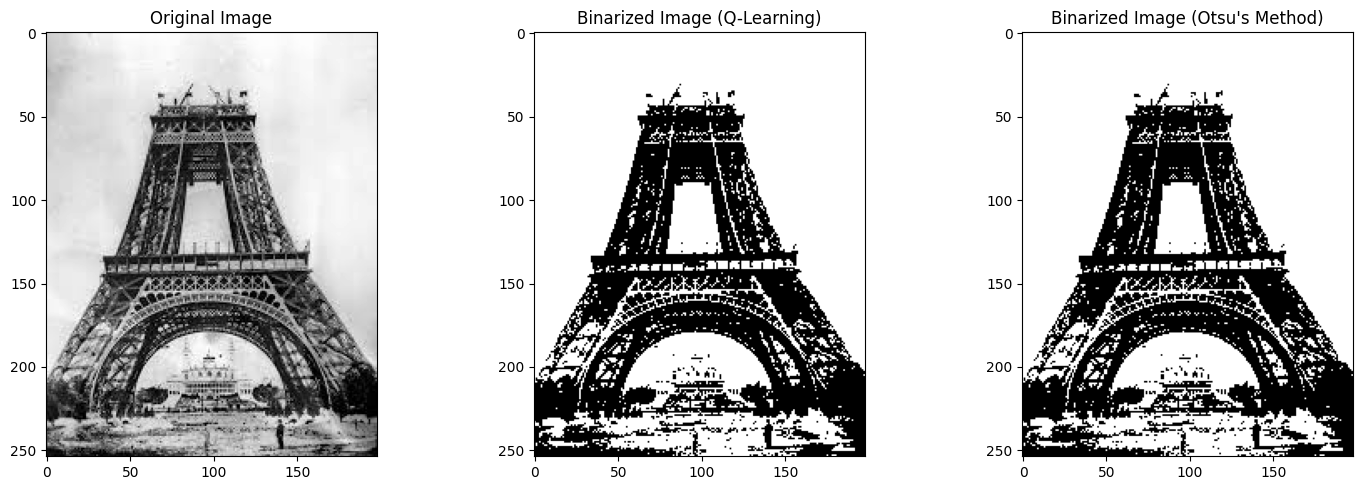

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time  # Import the time module

# Parameters for Q-Learning
learning_rate = 0.7
discount_factor = 0.9
epsilon = 1.0  # exploration rate
epsilon_decay = 0.995
min_epsilon = 0.1
num_episodes = 5000

# Environment parameters
threshold_levels = 256  # possible threshold levels (0-255)

# Initialize Q-table: threshold levels (256) x actions (2: binarize to 0 or 255)
q_table = np.zeros((threshold_levels, 2))

# Load image (convert to grayscale)
image = cv2.imread('paris.jfif', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print("Error: The image was not found or loaded correctly. Please check the file path.")
    exit()

def get_state(pixel_value):
    """Returns the state, which is the pixel value itself."""
    return pixel_value

def choose_action(state, epsilon):
    """Epsilon-greedy action selection."""
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice([0, 1])  # Explore: choose randomly between binarizing to 0 or 255
    else:
        return np.argmax(q_table[state, :])  # Exploit: choose the best action based on Q-table

def take_action(action):
    """Apply the chosen action: 0 (binarize to 0) or 1 (binarize to 255)."""
    return 0 if action == 0 else 255

def variance_intra_classe(image, threshold):
    """Calculate the intra-class variance for a given threshold, similar to Otsu's method."""
    pixel_counts = np.bincount(image.ravel(), minlength=256)
    total_pixels = image.size

    # Probabilities for each class
    weight_background = np.sum(pixel_counts[:threshold]) / total_pixels
    weight_foreground = np.sum(pixel_counts[threshold:]) / total_pixels

    # Mean values for each class
    mean_background = np.sum(np.arange(0, threshold) * pixel_counts[:threshold]) / (np.sum(pixel_counts[:threshold]) + 1e-7)
    mean_foreground = np.sum(np.arange(threshold, 256) * pixel_counts[threshold:]) / (np.sum(pixel_counts[threshold:]) + 1e-7)

    # Variance for each class
    variance_background = np.sum(((np.arange(0, threshold) - mean_background) ** 2) * pixel_counts[:threshold]) / (np.sum(pixel_counts[:threshold]) + 1e-7)
    variance_foreground = np.sum(((np.arange(threshold, 256) - mean_foreground) ** 2) * pixel_counts[threshold:]) / (np.sum(pixel_counts[threshold:]) + 1e-7)

    # Weighted sum of variances (intra-class variance)
    intra_class_variance = weight_background * variance_background + weight_foreground * variance_foreground

    return intra_class_variance

def reward_function(image, threshold):
    """Reward function based on minimizing intra-class variance."""
    intra_class_variance = variance_intra_classe(image, threshold)
    return -intra_class_variance  # Minimize variance, so negative reward

def calculate_entropy(image):
    """Calculate the entropy of the image."""
    histogram, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    histogram = histogram[histogram > 0]  # Ignore zero entries
    probabilities = histogram / histogram.sum()
    return -np.sum(probabilities * np.log2(probabilities))

# Measure the time taken for the Q-Learning process
start_time = time.time()

# Q-Learning process
for episode in range(num_episodes):
    for threshold in range(threshold_levels):
        # Simulate the action for the entire image at the current threshold
        _, binarized_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

        # Calculate reward based on intra-class variance
        reward = reward_function(image, threshold)

        # Update Q-table using Bellman Equation for both actions (binarize to 0 or 255)
        for action in [0, 1]:
            q_table[threshold, action] = q_table[threshold, action] + learning_rate * (
                reward + discount_factor * np.max(q_table[threshold, :]) - q_table[threshold, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

end_time = time.time()
print(f"Q-Learning process completed in {end_time - start_time:.2f} seconds.")

# Find the optimal threshold
optimal_threshold = np.argmax(np.max(q_table, axis=1))
print(f"Optimal threshold found by Q-learning: {optimal_threshold}")

# Measure the time taken for Otsu's method
start_time_otsu = time.time()

# Apply optimal threshold to the image using Q-learning
_, binarized_image_optimal = cv2.threshold(image, optimal_threshold, 255, cv2.THRESH_BINARY)

# Apply Otsu's method
optimal_threshold_otsu, binarized_image_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

end_time_otsu = time.time()
print(f"Otsu's method completed in {end_time_otsu - start_time_otsu:.2f} seconds.")
print(f"Optimal threshold found by Otsu's method: {optimal_threshold_otsu}")

# Calculate Entropy
entropy_q_learning = calculate_entropy(binarized_image_optimal)
entropy_otsu = calculate_entropy(binarized_image_otsu)

print(f"Entropy for Q-learning binarized image: {entropy_q_learning}")
print(f"Entropy for Otsu's method binarized image: {entropy_otsu}")

# Plot original image, Q-learning binarized image, and Otsu binarized image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Binarized Image (Q-Learning)')
plt.imshow(binarized_image_optimal, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Binarized Image (Otsu\'s Method)')
plt.imshow(binarized_image_otsu, cmap='gray')

plt.tight_layout()
plt.show()


## **l'entropie**

Q-Learning process completed in 693.99 seconds.
Optimal threshold found by Q-learning: 124
Otsu's method completed in 0.00 seconds.
Optimal threshold found by Otsu's method: 113.0
Entropy for Q-learning binarized image: 0.9993076292834523
Entropy for Otsu's method binarized image: 0.9968069257493657


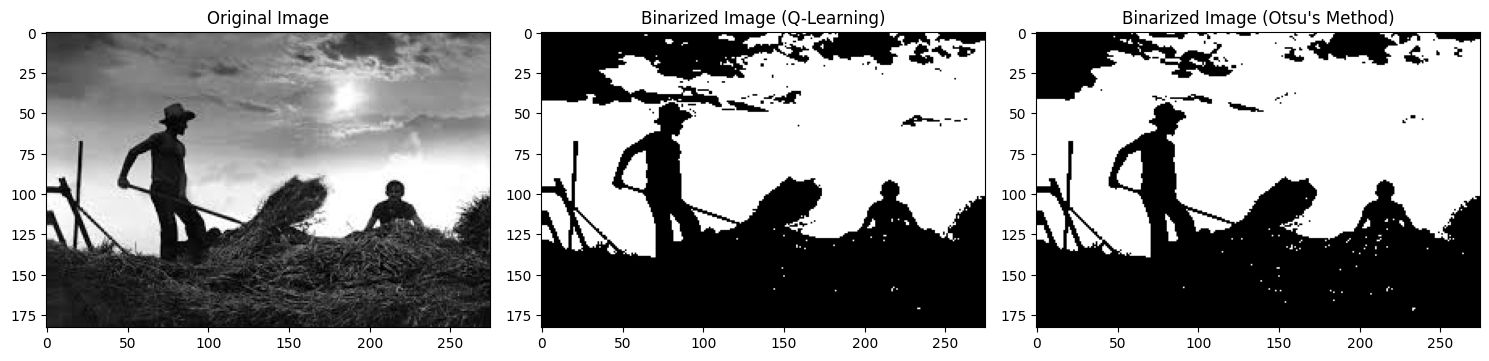

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time  # Import the time module

# Parameters for Q-Learning
learning_rate = 0.7
discount_factor = 0.9
epsilon = 1.0  # exploration rate
epsilon_decay = 0.995
min_epsilon = 0.1
num_episodes = 5000

# Environment parameters
threshold_levels = 256  # possible threshold levels (0-255)

# Initialize Q-table: threshold levels (256) x actions (2: binarize to 0 or 255)
q_table = np.zeros((threshold_levels, 2))

# Load image (convert to grayscale)
image = cv2.imread('jardinier.jfif', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print("Error: The image was not found or loaded correctly. Please check the file path.")
    exit()

def get_state(pixel_value):
    """Returns the state, which is the pixel value itself."""
    return pixel_value

def choose_action(state, epsilon):
    """Epsilon-greedy action selection."""
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice([0, 1])  # Explore: choose randomly between binarizing to 0 or 255
    else:
        return np.argmax(q_table[state, :])  # Exploit: choose the best action based on Q-table

def take_action(action):
    """Apply the chosen action: 0 (binarize to 0) or 1 (binarize to 255)."""
    return 0 if action == 0 else 255

def entropy(image, threshold):
    """Calculate the entropy for a given threshold."""
    pixel_counts = np.bincount(image.ravel(), minlength=256)
    total_pixels = image.size

    # Split pixel counts into two classes: below and above the threshold
    class_1 = pixel_counts[:threshold]
    class_2 = pixel_counts[threshold:]

    # Calculate probabilities for each class
    prob_class_1 = class_1 / np.sum(class_1 + 1e-7)
    prob_class_2 = class_2 / np.sum(class_2 + 1e-7)

    # Calculate entropy for each class (ignoring zero probabilities)
    entropy_class_1 = -np.sum([p * np.log2(p + 1e-7) for p in prob_class_1 if p > 0])
    entropy_class_2 = -np.sum([p * np.log2(p + 1e-7) for p in prob_class_2 if p > 0])

    # Total entropy (sum of both classes)
    total_entropy = entropy_class_1 + entropy_class_2

    return total_entropy

def reward_function(image, threshold):
    """Reward function based on maximizing entropy."""
    # Higher entropy means better thresholding, so we return a positive reward
    entropy_value = entropy(image, threshold)
    return entropy_value  # Maximize entropy, so positive reward

def calculate_entropy(image):
    """Calculate the entropy of the image."""
    histogram, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    histogram = histogram[histogram > 0]  # Ignore zero entries
    probabilities = histogram / histogram.sum()
    return -np.sum(probabilities * np.log2(probabilities))

# Measure the time taken for the Q-Learning process
start_time = time.time()

# Q-Learning process
for episode in range(num_episodes):
    for threshold in range(threshold_levels):
        # Simulate the action for the entire image at the current threshold
        _, binarized_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

        # Calculate reward based on entropy
        reward = reward_function(image, threshold)

        # Update Q-table using Bellman Equation for both actions (binarize to 0 or 255)
        for action in [0, 1]:
            q_table[threshold, action] = q_table[threshold, action] + learning_rate * (
                reward + discount_factor * np.max(q_table[threshold, :]) - q_table[threshold, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

end_time = time.time()
print(f"Q-Learning process completed in {end_time - start_time:.2f} seconds.")

# Find the optimal threshold
optimal_threshold = np.argmax(np.max(q_table, axis=1))
print(f"Optimal threshold found by Q-learning: {optimal_threshold}")

# Measure the time taken for Otsu's method
start_time_otsu = time.time()

# Apply optimal threshold to the image using Q-learning
_, binarized_image_optimal = cv2.threshold(image, optimal_threshold, 255, cv2.THRESH_BINARY)

# Apply Otsu's method
optimal_threshold_otsu, binarized_image_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

end_time_otsu = time.time()
print(f"Otsu's method completed in {end_time_otsu - start_time_otsu:.2f} seconds.")
print(f"Optimal threshold found by Otsu's method: {optimal_threshold_otsu}")

# Calculate Entropy
entropy_q_learning = calculate_entropy(binarized_image_optimal)
entropy_otsu = calculate_entropy(binarized_image_otsu)

print(f"Entropy for Q-learning binarized image: {entropy_q_learning}")
print(f"Entropy for Otsu's method binarized image: {entropy_otsu}")

# Plot original image, Q-learning binarized image, and Otsu binarized image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Binarized Image (Q-Learning)')
plt.imshow(binarized_image_optimal, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Binarized Image (Otsu\'s Method)')
plt.imshow(binarized_image_otsu, cmap='gray')

plt.tight_layout()
plt.show()


Q-Learning process completed in 697.15 seconds.
Optimal threshold found by Q-learning: 131
Otsu's method completed in 0.00 seconds.
Optimal threshold found by Otsu's method: 122.0
Entropy for Q-learning binarized image: 0.8508348192981795
Entropy for Otsu's method binarized image: 0.8947009158778796


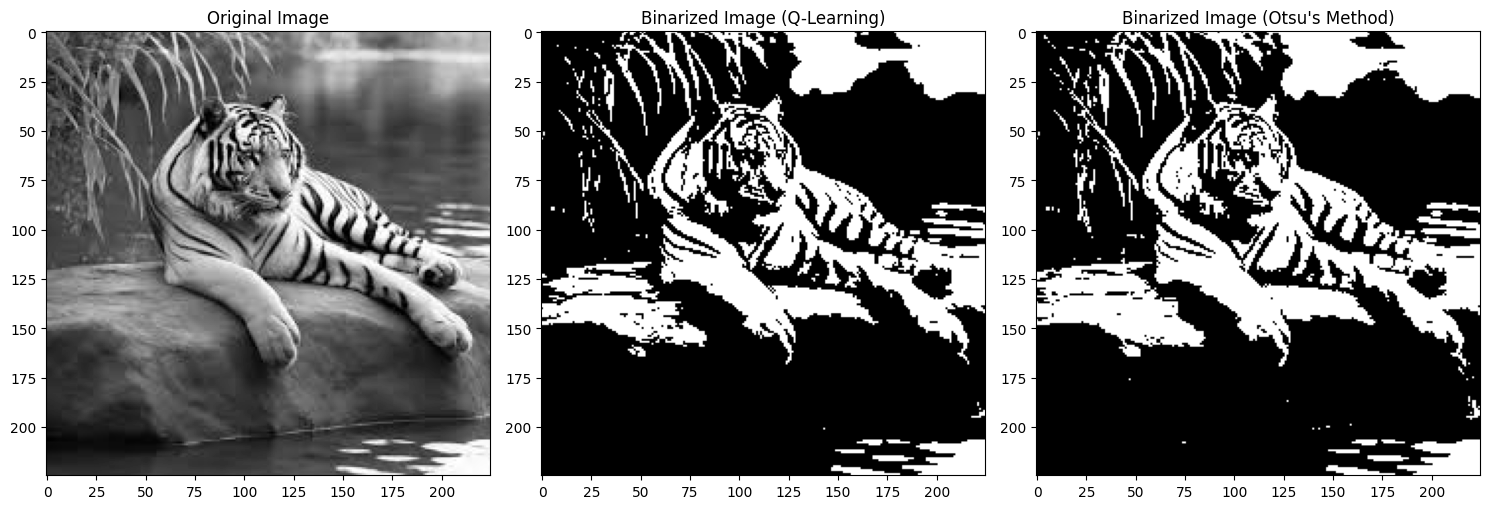

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time  # Import the time module

# Parameters for Q-Learning
learning_rate = 0.7
discount_factor = 0.9
epsilon = 1.0  # exploration rate
epsilon_decay = 0.995
min_epsilon = 0.1
num_episodes = 5000

# Environment parameters
threshold_levels = 256  # possible threshold levels (0-255)

# Initialize Q-table: threshold levels (256) x actions (2: binarize to 0 or 255)
q_table = np.zeros((threshold_levels, 2))

# Load image (convert to grayscale)
image = cv2.imread('riviere.jfif', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print("Error: The image was not found or loaded correctly. Please check the file path.")
    exit()

def get_state(pixel_value):
    """Returns the state, which is the pixel value itself."""
    return pixel_value

def choose_action(state, epsilon):
    """Epsilon-greedy action selection."""
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice([0, 1])  # Explore: choose randomly between binarizing to 0 or 255
    else:
        return np.argmax(q_table[state, :])  # Exploit: choose the best action based on Q-table

def take_action(action):
    """Apply the chosen action: 0 (binarize to 0) or 1 (binarize to 255)."""
    return 0 if action == 0 else 255

def entropy(image, threshold):
    """Calculate the entropy for a given threshold."""
    pixel_counts = np.bincount(image.ravel(), minlength=256)
    total_pixels = image.size

    # Split pixel counts into two classes: below and above the threshold
    class_1 = pixel_counts[:threshold]
    class_2 = pixel_counts[threshold:]

    # Calculate probabilities for each class
    prob_class_1 = class_1 / np.sum(class_1 + 1e-7)
    prob_class_2 = class_2 / np.sum(class_2 + 1e-7)

    # Calculate entropy for each class (ignoring zero probabilities)
    entropy_class_1 = -np.sum([p * np.log2(p + 1e-7) for p in prob_class_1 if p > 0])
    entropy_class_2 = -np.sum([p * np.log2(p + 1e-7) for p in prob_class_2 if p > 0])

    # Total entropy (sum of both classes)
    total_entropy = entropy_class_1 + entropy_class_2

    return total_entropy

def reward_function(image, threshold):
    """Reward function based on maximizing entropy."""
    # Higher entropy means better thresholding, so we return a positive reward
    entropy_value = entropy(image, threshold)
    return entropy_value  # Maximize entropy, so positive reward

def calculate_entropy(image):
    """Calculate the entropy of the image."""
    histogram, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    histogram = histogram[histogram > 0]  # Ignore zero entries
    probabilities = histogram / histogram.sum()
    return -np.sum(probabilities * np.log2(probabilities))

# Measure the time taken for the Q-Learning process
start_time = time.time()

# Q-Learning process
for episode in range(num_episodes):
    for threshold in range(threshold_levels):
        # Simulate the action for the entire image at the current threshold
        _, binarized_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

        # Calculate reward based on entropy
        reward = reward_function(image, threshold)

        # Update Q-table using Bellman Equation for both actions (binarize to 0 or 255)
        for action in [0, 1]:
            q_table[threshold, action] = q_table[threshold, action] + learning_rate * (
                reward + discount_factor * np.max(q_table[threshold, :]) - q_table[threshold, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

end_time = time.time()
print(f"Q-Learning process completed in {end_time - start_time:.2f} seconds.")

# Find the optimal threshold
optimal_threshold = np.argmax(np.max(q_table, axis=1))
print(f"Optimal threshold found by Q-learning: {optimal_threshold}")

# Measure the time taken for Otsu's method
start_time_otsu = time.time()

# Apply optimal threshold to the image using Q-learning
_, binarized_image_optimal = cv2.threshold(image, optimal_threshold, 255, cv2.THRESH_BINARY)

# Apply Otsu's method
optimal_threshold_otsu, binarized_image_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

end_time_otsu = time.time()
print(f"Otsu's method completed in {end_time_otsu - start_time_otsu:.2f} seconds.")
print(f"Optimal threshold found by Otsu's method: {optimal_threshold_otsu}")

# Calculate Entropy
entropy_q_learning = calculate_entropy(binarized_image_optimal)
entropy_otsu = calculate_entropy(binarized_image_otsu)

print(f"Entropy for Q-learning binarized image: {entropy_q_learning}")
print(f"Entropy for Otsu's method binarized image: {entropy_otsu}")

# Plot original image, Q-learning binarized image, and Otsu binarized image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Binarized Image (Q-Learning)')
plt.imshow(binarized_image_optimal, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Binarized Image (Otsu\'s Method)')
plt.imshow(binarized_image_otsu, cmap='gray')

plt.tight_layout()
plt.show()


Q-Learning process completed in 673.16 seconds.
Optimal threshold found by Q-learning: 114
Otsu's method completed in 0.00 seconds.
Optimal threshold found by Otsu's method: 107.0
Entropy for Q-learning binarized image: 0.9878269925157862
Entropy for Otsu's method binarized image: 0.9997091469098178


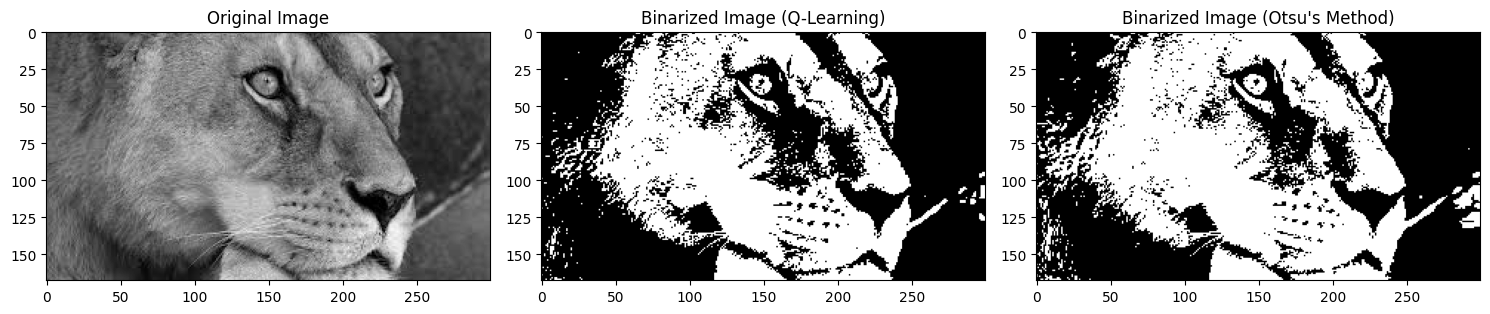

In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time  # Import the time module

# Parameters for Q-Learning
learning_rate = 0.7
discount_factor = 0.9
epsilon = 1.0  # exploration rate
epsilon_decay = 0.995
min_epsilon = 0.1
num_episodes = 5000

# Environment parameters
threshold_levels = 256  # possible threshold levels (0-255)

# Initialize Q-table: threshold levels (256) x actions (2: binarize to 0 or 255)
q_table = np.zeros((threshold_levels, 2))

# Load image (convert to grayscale)
image = cv2.imread('lion2.jfif', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print("Error: The image was not found or loaded correctly. Please check the file path.")
    exit()

def get_state(pixel_value):
    """Returns the state, which is the pixel value itself."""
    return pixel_value

def choose_action(state, epsilon):
    """Epsilon-greedy action selection."""
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice([0, 1])  # Explore: choose randomly between binarizing to 0 or 255
    else:
        return np.argmax(q_table[state, :])  # Exploit: choose the best action based on Q-table

def take_action(action):
    """Apply the chosen action: 0 (binarize to 0) or 1 (binarize to 255)."""
    return 0 if action == 0 else 255

def entropy(image, threshold):
    """Calculate the entropy for a given threshold."""
    pixel_counts = np.bincount(image.ravel(), minlength=256)
    total_pixels = image.size

    # Split pixel counts into two classes: below and above the threshold
    class_1 = pixel_counts[:threshold]
    class_2 = pixel_counts[threshold:]

    # Calculate probabilities for each class
    prob_class_1 = class_1 / np.sum(class_1 + 1e-7)
    prob_class_2 = class_2 / np.sum(class_2 + 1e-7)

    # Calculate entropy for each class (ignoring zero probabilities)
    entropy_class_1 = -np.sum([p * np.log2(p + 1e-7) for p in prob_class_1 if p > 0])
    entropy_class_2 = -np.sum([p * np.log2(p + 1e-7) for p in prob_class_2 if p > 0])

    # Total entropy (sum of both classes)
    total_entropy = entropy_class_1 + entropy_class_2

    return total_entropy

def reward_function(image, threshold):
    """Reward function based on maximizing entropy."""
    # Higher entropy means better thresholding, so we return a positive reward
    entropy_value = entropy(image, threshold)
    return entropy_value  # Maximize entropy, so positive reward

def calculate_entropy(image):
    """Calculate the entropy of the image."""
    histogram, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    histogram = histogram[histogram > 0]  # Ignore zero entries
    probabilities = histogram / histogram.sum()
    return -np.sum(probabilities * np.log2(probabilities))

# Measure the time taken for the Q-Learning process
start_time = time.time()

# Q-Learning process
for episode in range(num_episodes):
    for threshold in range(threshold_levels):
        # Simulate the action for the entire image at the current threshold
        _, binarized_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

        # Calculate reward based on entropy
        reward = reward_function(image, threshold)

        # Update Q-table using Bellman Equation for both actions (binarize to 0 or 255)
        for action in [0, 1]:
            q_table[threshold, action] = q_table[threshold, action] + learning_rate * (
                reward + discount_factor * np.max(q_table[threshold, :]) - q_table[threshold, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

end_time = time.time()
print(f"Q-Learning process completed in {end_time - start_time:.2f} seconds.")

# Find the optimal threshold
optimal_threshold = np.argmax(np.max(q_table, axis=1))
print(f"Optimal threshold found by Q-learning: {optimal_threshold}")

# Measure the time taken for Otsu's method
start_time_otsu = time.time()

# Apply optimal threshold to the image using Q-learning
_, binarized_image_optimal = cv2.threshold(image, optimal_threshold, 255, cv2.THRESH_BINARY)

# Apply Otsu's method
optimal_threshold_otsu, binarized_image_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

end_time_otsu = time.time()
print(f"Otsu's method completed in {end_time_otsu - start_time_otsu:.2f} seconds.")
print(f"Optimal threshold found by Otsu's method: {optimal_threshold_otsu}")

# Calculate Entropy
entropy_q_learning = calculate_entropy(binarized_image_optimal)
entropy_otsu = calculate_entropy(binarized_image_otsu)

print(f"Entropy for Q-learning binarized image: {entropy_q_learning}")
print(f"Entropy for Otsu's method binarized image: {entropy_otsu}")

# Plot original image, Q-learning binarized image, and Otsu binarized image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Binarized Image (Q-Learning)')
plt.imshow(binarized_image_optimal, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Binarized Image (Otsu\'s Method)')
plt.imshow(binarized_image_otsu, cmap='gray')

plt.tight_layout()
plt.show()


Q-Learning process completed in 693.16 seconds.
Optimal threshold found by Q-learning: 138
Otsu's method completed in 0.00 seconds.
Optimal threshold found by Otsu's method: 104.0
Entropy for Q-learning binarized image: 0.4336779864698601
Entropy for Otsu's method binarized image: 0.760041242925255


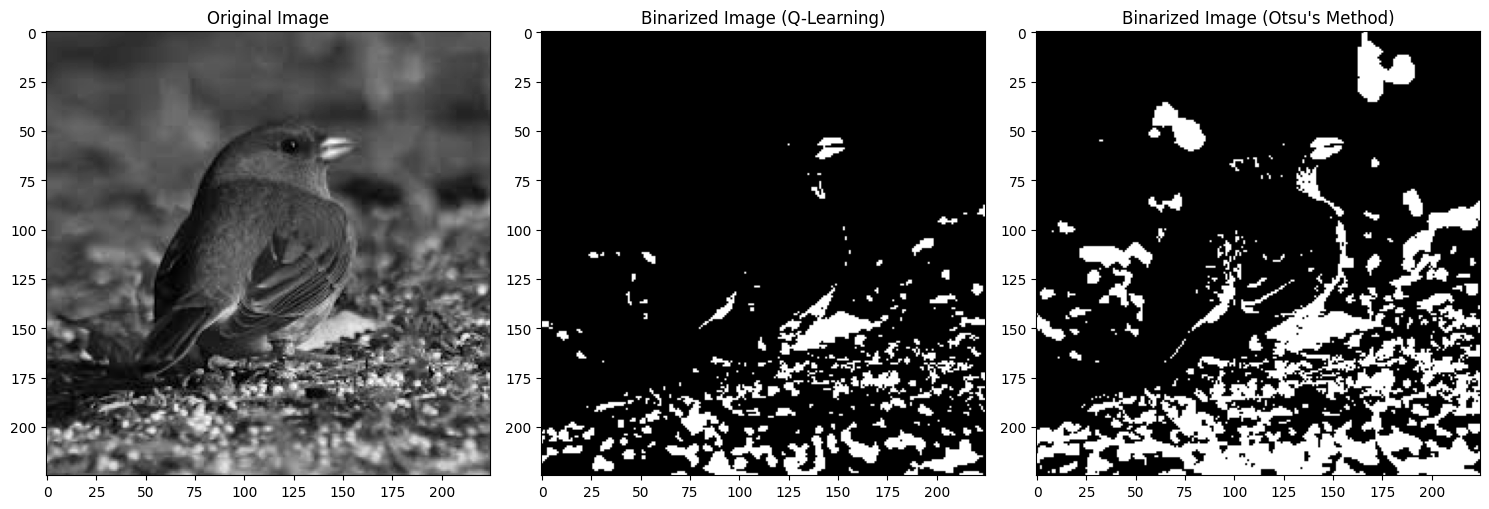

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time  # Import the time module

# Parameters for Q-Learning
learning_rate = 0.7
discount_factor = 0.9
epsilon = 1.0  # exploration rate
epsilon_decay = 0.995
min_epsilon = 0.1
num_episodes = 5000

# Environment parameters
threshold_levels = 256  # possible threshold levels (0-255)

# Initialize Q-table: threshold levels (256) x actions (2: binarize to 0 or 255)
q_table = np.zeros((threshold_levels, 2))

# Load image (convert to grayscale)
image = cv2.imread('oiseau.jfif', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print("Error: The image was not found or loaded correctly. Please check the file path.")
    exit()

def get_state(pixel_value):
    """Returns the state, which is the pixel value itself."""
    return pixel_value

def choose_action(state, epsilon):
    """Epsilon-greedy action selection."""
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice([0, 1])  # Explore: choose randomly between binarizing to 0 or 255
    else:
        return np.argmax(q_table[state, :])  # Exploit: choose the best action based on Q-table

def take_action(action):
    """Apply the chosen action: 0 (binarize to 0) or 1 (binarize to 255)."""
    return 0 if action == 0 else 255

def entropy(image, threshold):
    """Calculate the entropy for a given threshold."""
    pixel_counts = np.bincount(image.ravel(), minlength=256)
    total_pixels = image.size

    # Split pixel counts into two classes: below and above the threshold
    class_1 = pixel_counts[:threshold]
    class_2 = pixel_counts[threshold:]

    # Calculate probabilities for each class
    prob_class_1 = class_1 / np.sum(class_1 + 1e-7)
    prob_class_2 = class_2 / np.sum(class_2 + 1e-7)

    # Calculate entropy for each class (ignoring zero probabilities)
    entropy_class_1 = -np.sum([p * np.log2(p + 1e-7) for p in prob_class_1 if p > 0])
    entropy_class_2 = -np.sum([p * np.log2(p + 1e-7) for p in prob_class_2 if p > 0])

    # Total entropy (sum of both classes)
    total_entropy = entropy_class_1 + entropy_class_2

    return total_entropy

def reward_function(image, threshold):
    """Reward function based on maximizing entropy."""
    # Higher entropy means better thresholding, so we return a positive reward
    entropy_value = entropy(image, threshold)
    return entropy_value  # Maximize entropy, so positive reward

def calculate_entropy(image):
    """Calculate the entropy of the image."""
    histogram, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    histogram = histogram[histogram > 0]  # Ignore zero entries
    probabilities = histogram / histogram.sum()
    return -np.sum(probabilities * np.log2(probabilities))

# Measure the time taken for the Q-Learning process
start_time = time.time()

# Q-Learning process
for episode in range(num_episodes):
    for threshold in range(threshold_levels):
        # Simulate the action for the entire image at the current threshold
        _, binarized_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

        # Calculate reward based on entropy
        reward = reward_function(image, threshold)

        # Update Q-table using Bellman Equation for both actions (binarize to 0 or 255)
        for action in [0, 1]:
            q_table[threshold, action] = q_table[threshold, action] + learning_rate * (
                reward + discount_factor * np.max(q_table[threshold, :]) - q_table[threshold, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

end_time = time.time()
print(f"Q-Learning process completed in {end_time - start_time:.2f} seconds.")

# Find the optimal threshold
optimal_threshold = np.argmax(np.max(q_table, axis=1))
print(f"Optimal threshold found by Q-learning: {optimal_threshold}")

# Measure the time taken for Otsu's method
start_time_otsu = time.time()

# Apply optimal threshold to the image using Q-learning
_, binarized_image_optimal = cv2.threshold(image, optimal_threshold, 255, cv2.THRESH_BINARY)

# Apply Otsu's method
optimal_threshold_otsu, binarized_image_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

end_time_otsu = time.time()
print(f"Otsu's method completed in {end_time_otsu - start_time_otsu:.2f} seconds.")
print(f"Optimal threshold found by Otsu's method: {optimal_threshold_otsu}")

# Calculate Entropy
entropy_q_learning = calculate_entropy(binarized_image_optimal)
entropy_otsu = calculate_entropy(binarized_image_otsu)

print(f"Entropy for Q-learning binarized image: {entropy_q_learning}")
print(f"Entropy for Otsu's method binarized image: {entropy_otsu}")

# Plot original image, Q-learning binarized image, and Otsu binarized image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Binarized Image (Q-Learning)')
plt.imshow(binarized_image_optimal, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Binarized Image (Otsu\'s Method)')
plt.imshow(binarized_image_otsu, cmap='gray')

plt.tight_layout()
plt.show()
